<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Gene_expression_Inflammatory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook id to examine the expression pattern of HATs, HDACs, Inflammatory related and NFkB related pathways in both ES/EB and MEF systems to see if the genes are upregulated or downregulated using a Treatment and control

In [ ]:
start_time0 <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment', 'limma', 'goseq', 
  'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'org.Mm.eg.db',
  'wordcloud', 'plotrix', 'DESeq2','clusterProfiler','VennDiagram','fgsea','cowplot'
), Ncpus = 2)
install.packages(c('farver', "Seurat"), Ncpus = 2)
install.packages('devtools')
devtools::install_github('rstudio/reticulate')
devtools::install_github("GSEA-MSigDB/GSEA_R")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.5 (2021-03-31)

Installing package(s) 'SummarizedExperiment', 'rhdf5', 'SingleCellExperiment',
  'limma', 'goseq', 'stringr', 'ggplot2', 'TxDb.Mmusculus.UCSC.mm10.knownGene',
  'org.Mm.eg.db', 'wordcloud', 'plotrix', 'DESeq2', 'clusterProfiler'

Warning message in install.packages(...):
“installation of one or more packages failed,
  probably ‘SummarizedExperiment’, ‘limma’, ‘goseq’, ‘stringr’, ‘ggplot2’, ‘TxDb.Mmusculus.UCSC.mm10.knownGene’, ‘org.Mm.eg.db’, ‘wordcloud’, ‘plotrix’, ‘clusterProfiler’, ‘SingleCellExperiment’, ‘DESeq2’”
Old packages: 'brio', 'callr', 'cli', 'colorspace', 'curl', 'devtools',
  'dplyr', 'ellipsis', 'gh', 'haven', 'knitr', 'openssl', 'processx', 'rlang',
  'tidyselect', 'vctrs', 'boot', 'class', 'cluster', 'KernSmooth', 'lattice',
  'MASS', 'Mat

In [ ]:
library(SummarizedExperiment)
library(RColorBrewer)
library(plyr)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)
library(DESeq2)
library(GSEA)
library(fgsea)
library(VennDiagram)
library(cowplot)

Loading required package: annotate

Loading required package: XML

Loading required package: Heatplus

Loading required package: BMA

Loading required package: survival

Loading required package: leaps

Loading required package: robustbase


Attaching package: ‘robustbase’


The following object is masked from ‘package:survival’:

    heart


The following object is masked from ‘package:Biobase’:

    rowMedians


The following objects are masked from ‘package:MatrixGenerics’:

    colMedians, rowMedians


The following objects are masked from ‘package:matrixStats’:

    colMedians, rowMedians


Loading required package: inline

Loading required package: rrcov

Scalable Robust Estimators with High Breakdown Point (version 1.5-5)


Loading required package: Hmisc

Loading required package: lattice

Loading required package: Formula


Attaching package: ‘Hmisc’


The following object is masked from ‘package:AnnotationDbi’:

    contents


The following objects are masked from ‘package:dp

# Loading the gene list obtained from GO containg 4 categories (Hats, HDACs, Inflammatory related and NFkB pathwway related)
https://www.ebi.ac.uk/QuickGO/annotations?goUsage=descendants&goUsageRelationships=is_a,part_of,occurs_in&goId=GO:0004402&taxonId=10090&taxonUsage=descendants

In [ ]:
gene_list <- c(
  "nfkb" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Nf_kB.tsv",
  "hdac" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/HDAC_complex.tsv",
  "hat" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Hat.tsv",
  "inflammatory" = "https://s3.msi.umn.edu/dsouz072/datasets/dataset=etv2_pioneer=20210404a/Inflammatory_go.tsv")

In [ ]:
for (i in 1:length(gene_list)){
  sprintf('wget -x -c -nH %s', gene_list[i]) %>% system()
}
gene_list <- gsub('https://s3.msi.umn.edu/', './', gene_list)
message(sprintf('all gene_list exist: %s', all(file.exists(gene_list))))

all gene_list exist: TRUE



In [ ]:
genes <- lapply(gene_list, function(g){read.table(g, header = TRUE, sep = '\t')})

In [ ]:
unique(genes[["hdac"]]$GO.NAME)

[1] "Swr1 complex"                "Sin3 complex"               
[3] "histone deacetylase complex" "NuRD complex"               
[5] "Sin3-type complex"

In [ ]:
genes[["hdac_sub"]] <- genes[["hdac"]][grepl('histone', genes[["hdac"]]$GO.NAME),] #Subsetting Histone Deactylase complex

## Load processed scRNA-seq data

In [ ]:
se_file <- c(
  "se" = "https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds")

In [ ]:
for (i in 1:length(se_file)){
  sprintf('wget -x -c -nH %s', se_file[i]) %>% system()
}
se_file <- gsub('https://s3.msi.umn.edu/', './', se_file)
message(sprintf('all se_file exist: %s', all(file.exists(se_file))))

all se_file exist: TRUE



In [ ]:
se <- se_file %>%
  readRDS()

In [ ]:
se

class: SummarizedExperiment 
dim: 17010 15475 
metadata(1): curves
assays(3): counts normalized_counts scaled_counts
rownames: NULL
rowData names(6): id name ... is_hvg clusters
colnames: NULL
colData names(7): barcodes group ... umap cluster

## Calculating Diferential expression for Treatment (MEF_Dox_D7b) vs Control (MEF_NoDox)

In [ ]:
X <- assays(se)$scaled_counts
clust <- colData(se)$cluster
control <- colData(se)$group == 'MEF_NoDox'
treatment <- colData(se)$group == 'MEF_Dox_D7b'
pvalues_tc <- mclapply(
  1:nrow(X), function(i) wilcox.test(X[i, treatment], X[i, control], alternative = 'two.sided')$p.value,
  mc.cores = 4) %>% unlist()
names(pvalues_tc) <- names(fc_tc) <- rowData(se)$name

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [ ]:
fc_tc <- rowMeans(assays(se)$normalized_counts[, treatment]+1)/rowMeans(assays(se)$normalized_counts[, control]+1)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [ ]:
res_scrna <- data.frame(
  name = rowData(se)$name, 
  fc = fc_tc, 
  pvalue = pvalues_tc
)

In [ ]:
res_scrna$log2fc <- log2(fc_tc)

In [ ]:
head(res_scrna)

,name,fc,pvalue,log2fc
,<chr>,<dbl>,<dbl>,<dbl>
1,Mrpl15,0.8561015,1.588210e-40,-0.224146290
2,Lypla1,0.9869158,1.476162e-09,-0.019001027
3,Gm37988,0.9997660,4.958114e-01,-0.000337565
4,Tcea1,0.8246107,3.610119e-43,-0.278214927
5,Rgs20,0.9858808,2.354869e-05,-0.020514837
6,Atp6v1h,1.1638874,4.307872e-07,0.218951431


## Subsetting the genes as up-regulated, down-regulated for the treatment

In [ ]:
up <- res_scrna %>%
  filter(!is.na(pvalue) & log2fc > 0 & pvalue <0.05)

In [ ]:
down <- res_scrna %>%
  filter(!is.na(pvalue) & log2fc < 0 & pvalue < 0.05)

In [ ]:
dim(up)
dim(down)

[1] 3829    4

[1] 6944    4

#RNAseq

## Looking up genes for each of the 5 categories (Hats, HDACs, HDACs complex, Inflammatory related and NFkB pathwway related) in the up regulated and downregulated genes (treatment)

UP

In [ ]:
up_genes <- lapply(1:length(genes),function(x){up[up$name %in% genes[[x]]$SYMBOL,]})

In [ ]:
names(up_genes) <- names(genes)

In [ ]:
str(up_genes)

List of 5
 $ nfkb        :'data.frame':	6 obs. of  4 variables:
  ..$ name  : chr [1:6] "Ikbke" "Traf2" "Tlr4" "Relb" ...
  ..$ fc    : num [1:6] 1.04 1 1.06 1 1.03 ...
  ..$ pvalue: num [1:6] 2.20e-05 7.88e-04 4.46e-11 2.42e-02 3.90e-04 ...
  ..$ log2fc: num [1:6] 0.053 0.00593 0.08558 0.00684 0.04017 ...
 $ hdac        :'data.frame':	24 obs. of  4 variables:
  ..$ name  : chr [1:24] "Satb2" "Dnttip1" "Zfp217" "Hdac6" ...
  ..$ fc    : num [1:24] 1.01 1.02 1.11 1.01 1 ...
  ..$ pvalue: num [1:24] 1.31e-02 2.05e-04 5.68e-08 6.51e-03 1.14e-02 ...
  ..$ log2fc: num [1:24] 0.01685 0.02411 0.14849 0.01297 0.00481 ...
 $ hat         :'data.frame':	13 obs. of  4 variables:
  ..$ name  : chr [1:13] "Atf2" "Ncoa3" "Gtf2b" "Supt7l" ...
  ..$ fc    : num [1:13] 1.04 1.03 1.05 1.01 1.02 ...
  ..$ pvalue: num [1:13] 0.017125 0.017757 0.012629 0.008127 0.000104 ...
  ..$ log2fc: num [1:13] 0.0546 0.0445 0.0714 0.0127 0.0265 ...
 $ inflammatory:'data.frame':	105 obs. of  4 variables:
  ..$ name  : c

DOWN

In [ ]:
down_genes <- lapply(1:length(genes),function(x){down[down$name %in% genes[[x]]$SYMBOL,]})

In [ ]:
names(down_genes) <- names(genes)

In [ ]:
str(down_genes)

List of 5
 $ nfkb        :'data.frame':	16 obs. of  4 variables:
  ..$ name  : chr [1:16] "Cops8" "Traf6" "Irak1" "Ikbkg" ...
  ..$ fc    : num [1:16] 0.857 0.99 0.94 0.988 0.999 ...
  ..$ pvalue: num [1:16] 1.11e-40 5.22e-08 2.31e-23 5.50e-09 4.40e-09 ...
  ..$ log2fc: num [1:16] -0.22347 -0.01499 -0.08877 -0.01797 -0.00118 ...
 $ hdac        :'data.frame':	36 obs. of  4 variables:
  ..$ name  : chr [1:36] "Hdac4" "Csnk2a1" "Tbl1x" "Anp32e" ...
  ..$ fc    : num [1:36] 0.992 0.889 0.878 0.749 0.963 ...
  ..$ pvalue: num [1:36] 1.28e-08 5.03e-29 6.20e-28 1.11e-92 9.24e-13 ...
  ..$ log2fc: num [1:36] -0.0118 -0.1692 -0.1869 -0.4169 -0.0542 ...
 $ hat         :'data.frame':	21 obs. of  4 variables:
  ..$ name  : chr [1:21] "Gtf3c4" "Mettl8" "Hat1" "Kat14" ...
  ..$ fc    : num [1:21] 0.984 0.999 0.773 0.965 0.97 ...
  ..$ pvalue: num [1:21] 2.62e-11 1.16e-04 2.86e-94 2.46e-16 3.07e-13 ...
  ..$ log2fc: num [1:21] -0.02339 -0.00182 -0.37185 -0.0514 -0.04333 ...
 $ inflammatory:'data.fram

## Load the bulk RNA-seq of Etv2 induction in ES/EB and calculating Differential expression of treatment (EB_Dox_D25_Flk1pos_Etv2) vs control (EB_NoDox_D25_Etv2)

In [ ]:
se_rna <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))
se_rna <- DESeqDataSet(se_rna, design = ~ group)
se_rna <- estimateSizeFactors(se_rna)
se_rna <- DESeq(se_rna)
table(colData(se_rna)$group)
res <- results(se_rna, contrast = c('group', 'EB_Dox_D25_Flk1pos_Etv2', 'EB_NoDox_D25_Etv2'))

Warning message in DESeqDataSet(se_rna, design = ~group):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




         EB_Dox_D2_Etv2         EB_Dox_D25_Etv2 EB_Dox_D25_Flk1pos_Etv2 
                      2                       2                       2 
       EB_NoDox_D2_Etv2       EB_NoDox_D25_Etv2 
                      2                       2 

In [ ]:
head(res)

log2 fold change (MLE): group EB_Dox_D25_Flk1pos_Etv2 vs EB_NoDox_D25_Etv2 
Wald test p-value: group EB_Dox_D25_Flk1pos_Etv2 vs EB_NoDox_D25_Etv2 
DataFrame with 6 rows and 6 columns
               baseMean log2FoldChange     lfcSE       stat      pvalue
              <numeric>      <numeric> <numeric>  <numeric>   <numeric>
0610005C13Rik   22.5079      2.2176660  0.749898  2.9572892 0.003103568
0610007C21Rik  317.4460      0.3328445  0.226857  1.4671992 0.142321886
0610007L01Rik 2692.5195     -0.3353582  0.101905 -3.2909007 0.000998672
0610007N19Rik   78.4967     -0.0255568  0.346032 -0.0738567 0.941124427
0610007P08Rik 1393.9053      0.0461691  0.121432  0.3802055 0.703792879
0610007P14Rik 1402.6347     -0.0875989  0.137903 -0.6352198 0.525285091
                    padj
               <numeric>
0610005C13Rik 0.00845671
0610007C21Rik 0.23300793
0610007L01Rik 0.00302910
0610007N19Rik 0.97192676
0610007P08Rik 0.79528900
0610007P14Rik 0.64609835

## Subsetting the genes as up-regulated, down-regulated for the treatment

In [ ]:
up_rna <- as.data.frame(res) %>%
  filter(pvalue < 0.05 & log2FoldChange > 0)

In [ ]:
down_rna <- as.data.frame(res) %>%
  filter(pvalue < 0.05 & log2FoldChange < 0)

In [ ]:
dim(up_rna)
dim(down_rna)

[1] 4365    6

[1] 4277    6

## Looking up genes for each of the 5 categories (Hats, HDACs, HDACs complex, Inflammatory related and NFkB pathwway related) in the up regulated and downregulated genes (treatment)

In [ ]:
up_rna_genes <- lapply(1:length(genes),function(x){up_rna[rownames(up_rna) %in% genes[[x]]$SYMBOL,]})
names(up_rna_genes) <- names(genes)

In [ ]:
str(up_rna_genes)

List of 5
 $ nfkb        :'data.frame':	14 obs. of  6 variables:
  ..$ baseMean      : num [1:14] 3045.9 985 1768.1 5287.3 18.4 ...
  ..$ log2FoldChange: num [1:14] 0.714 1.06 0.241 0.273 2.632 ...
  ..$ lfcSE         : num [1:14] 0.106 0.146 0.107 0.121 0.794 ...
  ..$ stat          : num [1:14] 6.71 7.26 2.24 2.26 3.31 ...
  ..$ pvalue        : num [1:14] 1.97e-11 3.92e-13 2.49e-02 2.36e-02 9.22e-04 ...
  ..$ padj          : num [1:14] 1.74e-10 4.03e-12 5.34e-02 5.09e-02 2.82e-03 ...
 $ hdac        :'data.frame':	17 obs. of  6 variables:
  ..$ baseMean      : num [1:17] 5179 779 717 327 2715 ...
  ..$ log2FoldChange: num [1:17] 0.387 0.564 0.407 1.021 0.291 ...
  ..$ lfcSE         : num [1:17] 0.113 0.128 0.146 0.174 0.101 ...
  ..$ stat          : num [1:17] 3.41 4.41 2.78 5.85 2.88 ...
  ..$ pvalue        : num [1:17] 6.42e-04 1.06e-05 5.44e-03 4.79e-09 3.99e-03 ...
  ..$ padj          : num [1:17] 2.02e-03 4.58e-05 1.39e-02 3.28e-08 1.06e-02 ...
 $ hat         :'data.frame':	8 obs

In [ ]:
down_rna_genes <- lapply(1:length(genes),function(x){down_rna[rownames(down_rna) %in% genes[[x]]$SYMBOL,]})
names(down_rna_genes) <- names(genes)

# Common up and down regulated genes in treatment between ES/EB (blue) and MEF(yellow)

## HAT's

UP_HATs

(polygon[GRID.polygon.3867], polygon[GRID.polygon.3868], polygon[GRID.polygon.3869], polygon[GRID.polygon.3870], text[GRID.text.3871], text[GRID.text.3872], text[GRID.text.3873], text[GRID.text.3874], text[GRID.text.3875]) 

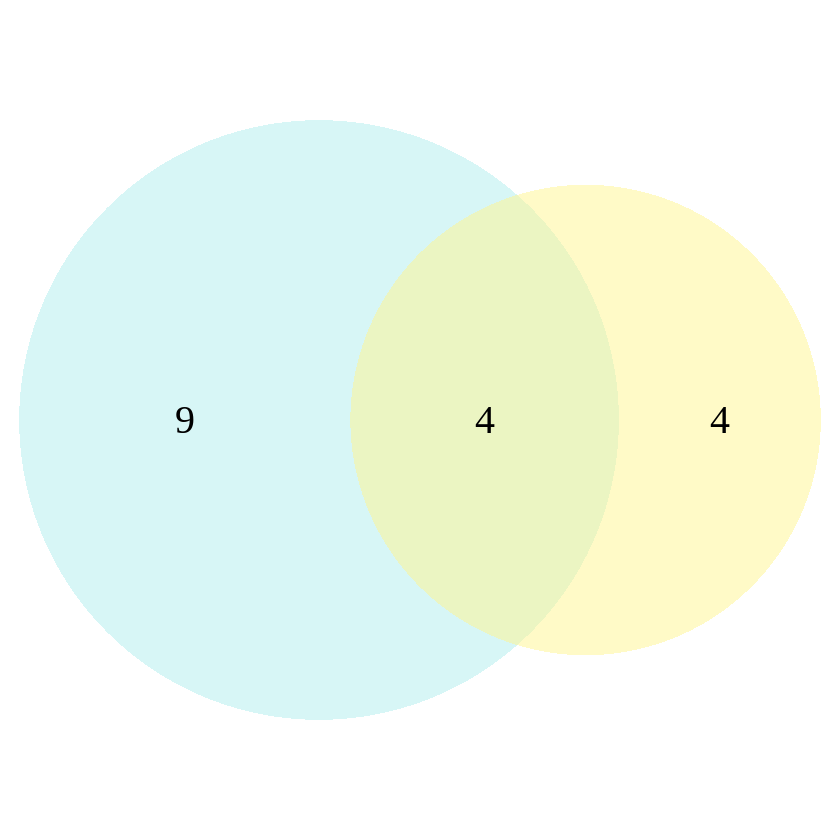

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
draw.pairwise.venn(
  area1 = length(up_genes[['hat']]$name),
  area2 = length(rownames(up_rna_genes[['hat']])),
  cross.area = length(intersect(rownames(up_rna_genes[['hat']]), up_genes[['hat']]$name)),
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1
)

DOWN_HATs

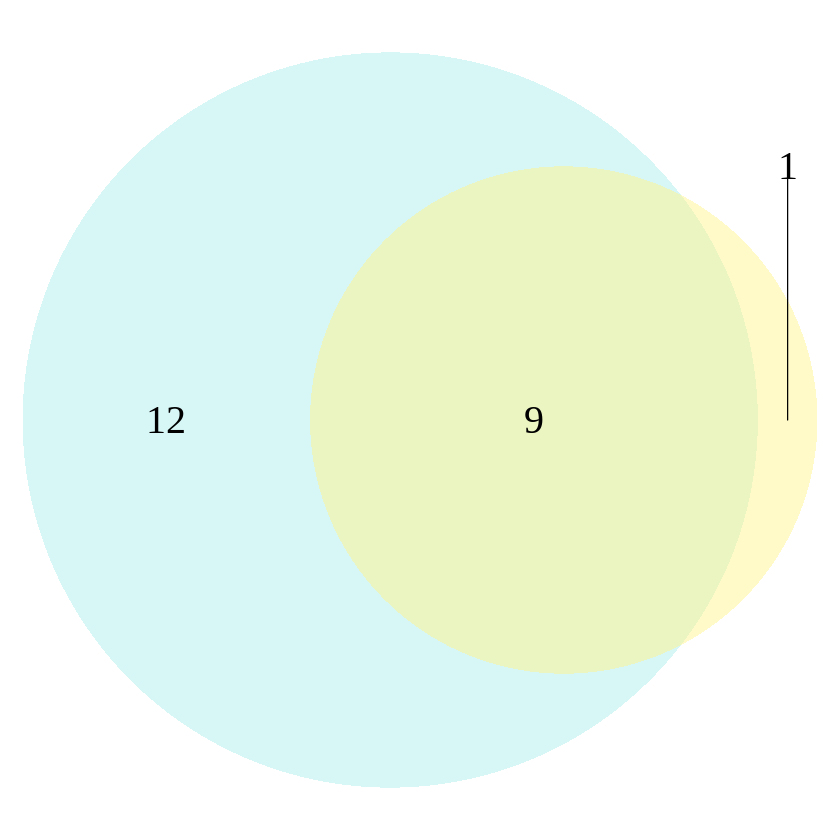

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
venn <- draw.pairwise.venn(
  area1 = length(down_genes[['hat']]$name),
  area2 = length(rownames(down_rna_genes[['hat']])),
  cross.area = length(intersect(rownames(down_rna_genes[['hat']]), down_genes[['hat']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1
)

## HDAC

UP_HDACs

(polygon[GRID.polygon.3831], polygon[GRID.polygon.3832], polygon[GRID.polygon.3833], polygon[GRID.polygon.3834], text[GRID.text.3835], text[GRID.text.3836], text[GRID.text.3837], text[GRID.text.3838], text[GRID.text.3839]) 

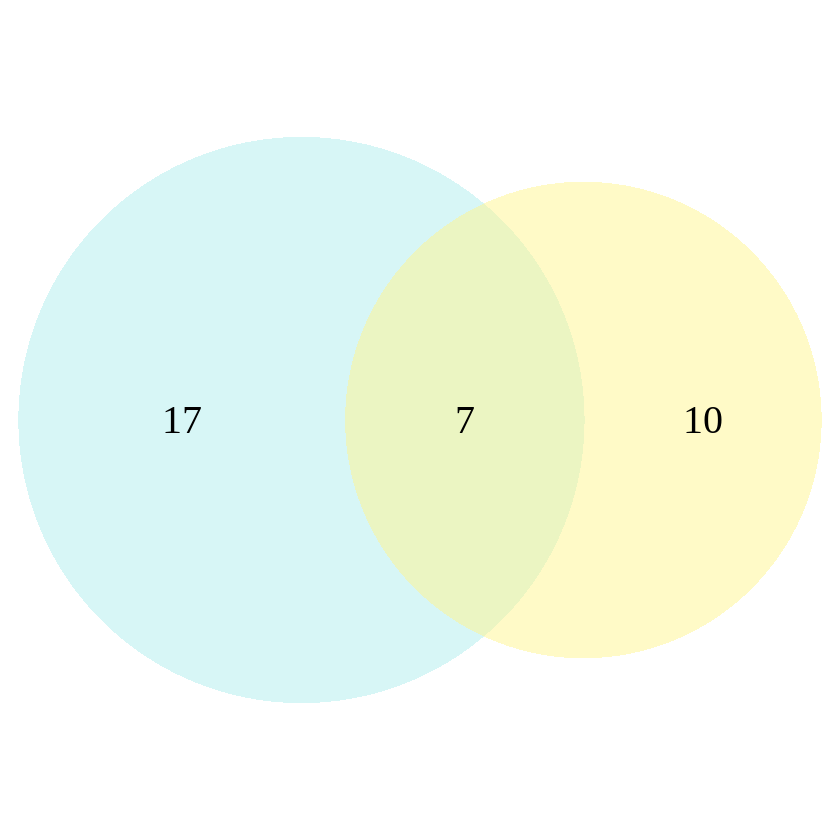

In [ ]:
draw.pairwise.venn(
  area1 = length(up_genes[['hdac']]$name),
  area2 = length(rownames(up_rna_genes[['hdac']])),
  cross.area = length(intersect(rownames(up_rna_genes[['hdac']]), up_genes[['hdac']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1)

UP_HDACs_only_histonedeacytelase complex

(polygon[GRID.polygon.3840], polygon[GRID.polygon.3841], polygon[GRID.polygon.3842], polygon[GRID.polygon.3843], text[GRID.text.3844], text[GRID.text.3845], text[GRID.text.3846], text[GRID.text.3847], text[GRID.text.3848]) 

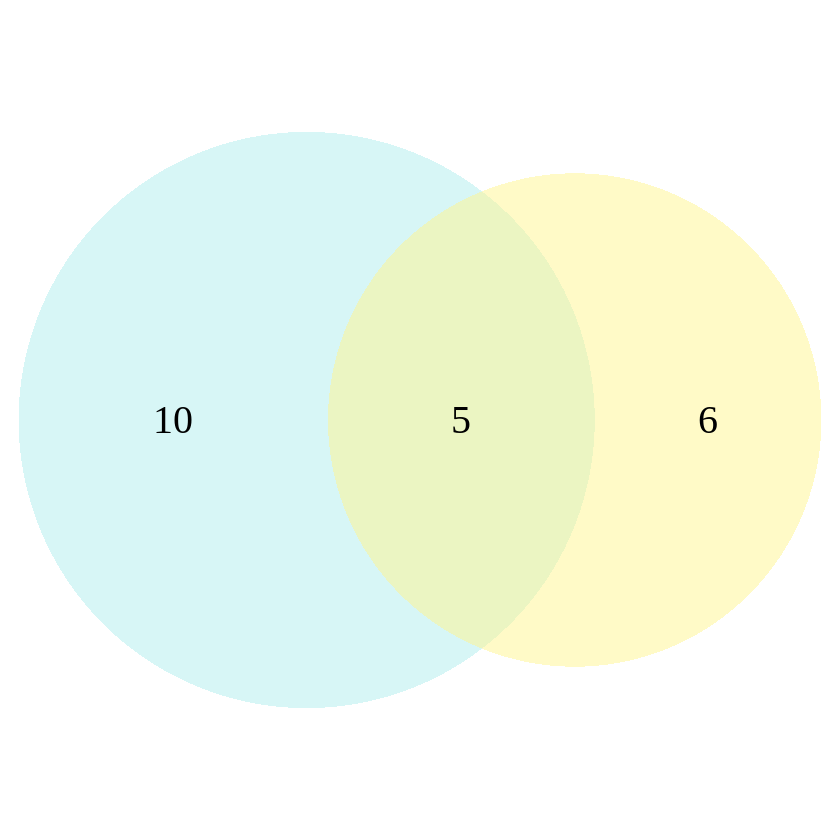

In [ ]:
draw.pairwise.venn(
  area1 = length(up_genes[['hdac_sub']]$name),
  area2 = length(rownames(up_rna_genes[['hdac_sub']])),
  cross.area = length(intersect(rownames(up_rna_genes[['hdac_sub']]), up_genes[['hdac_sub']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1)

DOWN_HDACs

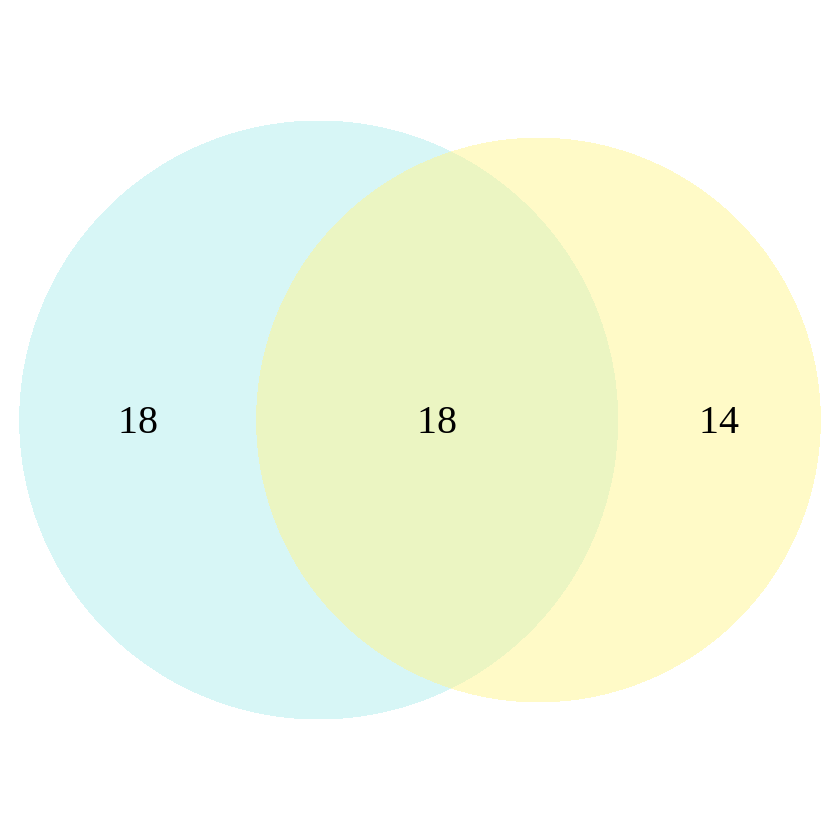

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
venn <- draw.pairwise.venn(
  area1 = length(down_genes[['hdac']]$name),
  area2 = length(rownames(down_rna_genes[['hdac']])),
  cross.area = length(intersect(rownames(down_rna_genes[['hdac']]), down_genes[['hdac']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1
)

DOWN_HDACs_only_histonedeacytelase complex

(polygon[GRID.polygon.3876], polygon[GRID.polygon.3877], polygon[GRID.polygon.3878], polygon[GRID.polygon.3879], text[GRID.text.3880], text[GRID.text.3881], text[GRID.text.3882], text[GRID.text.3883], text[GRID.text.3884]) 

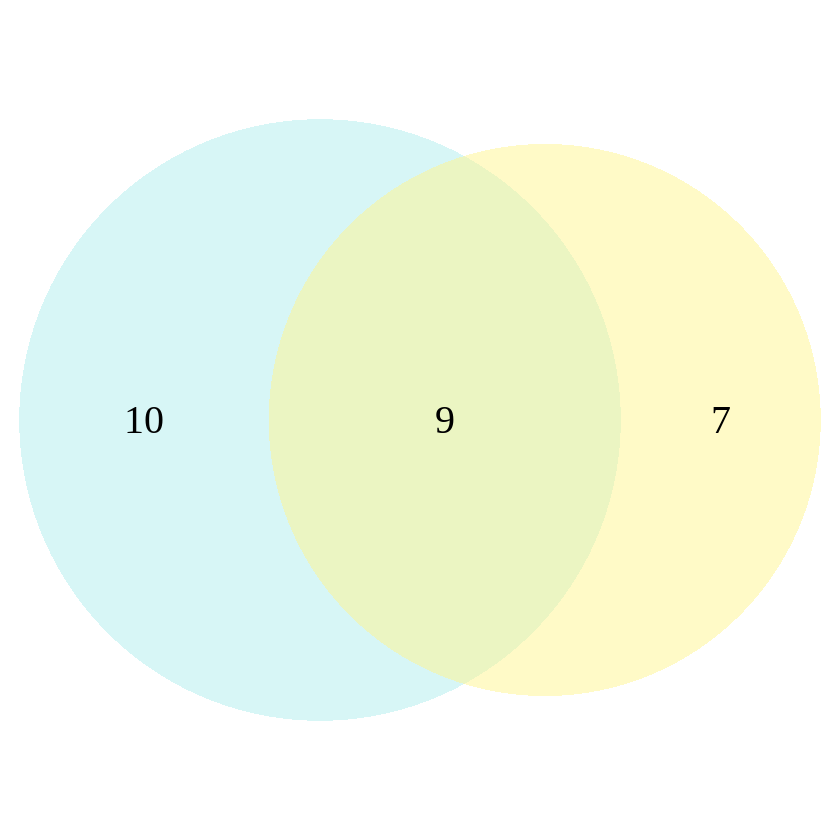

In [ ]:
draw.pairwise.venn(
  area1 = length(down_genes[['hdac_sub']]$name),
  area2 = length(rownames(down_rna_genes[['hdac_sub']])),
  cross.area = length(intersect(rownames(down_rna_genes[['hdac_sub']]), down_genes[['hdac_sub']]$name)), 
  lty = "blank", 
  fill =  c( "khaki1","paleturquoise"),
  cex = 2,
  cat.cex = 1)


## Inflammatory

UP_Inflammatory

(polygon[GRID.polygon.3885], polygon[GRID.polygon.3886], polygon[GRID.polygon.3887], polygon[GRID.polygon.3888], text[GRID.text.3889], text[GRID.text.3890], text[GRID.text.3891], text[GRID.text.3892], text[GRID.text.3893]) 

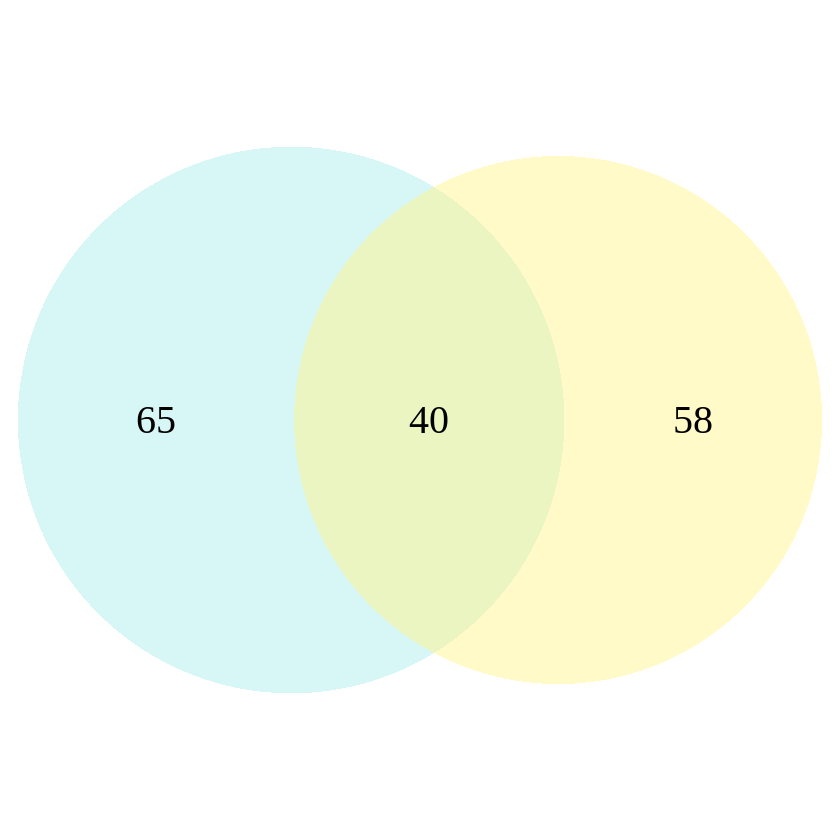

In [ ]:
draw.pairwise.venn(
  area1 = length(up_genes[['inflammatory']]$name),
  area2 = length(rownames(up_rna_genes[['inflammatory']])),
  cross.area = length(intersect(rownames(up_rna_genes[['inflammatory']]), up_genes[['inflammatory']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1)

DOWN_Inflammatory

(polygon[GRID.polygon.3894], polygon[GRID.polygon.3895], polygon[GRID.polygon.3896], polygon[GRID.polygon.3897], text[GRID.text.3898], text[GRID.text.3899], text[GRID.text.3900], text[GRID.text.3901], text[GRID.text.3902]) 

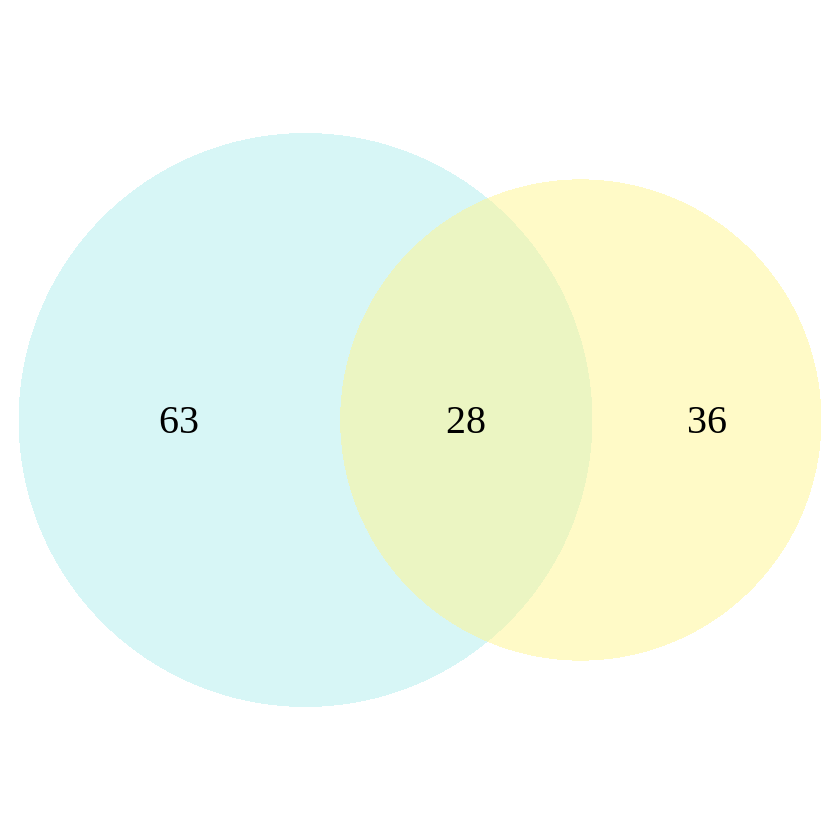

In [ ]:
draw.pairwise.venn(
  area1 = length(down_genes[['inflammatory']]$name),
  area2 = length(rownames(down_rna_genes[['inflammatory']])),
  cross.area = length(intersect(rownames(down_rna_genes[['inflammatory']]), down_genes[['inflammatory']]$name)), 
  lty = "blank", 
  fill = c("paleturquoise", "khaki1"),
  cex = 2,
  cat.cex = 1)

## NFkB

UP_NFkB

(polygon[GRID.polygon.3903], polygon[GRID.polygon.3904], polygon[GRID.polygon.3905], polygon[GRID.polygon.3906], text[GRID.text.3907], text[GRID.text.3908], text[GRID.text.3909], text[GRID.text.3910], text[GRID.text.3911]) 

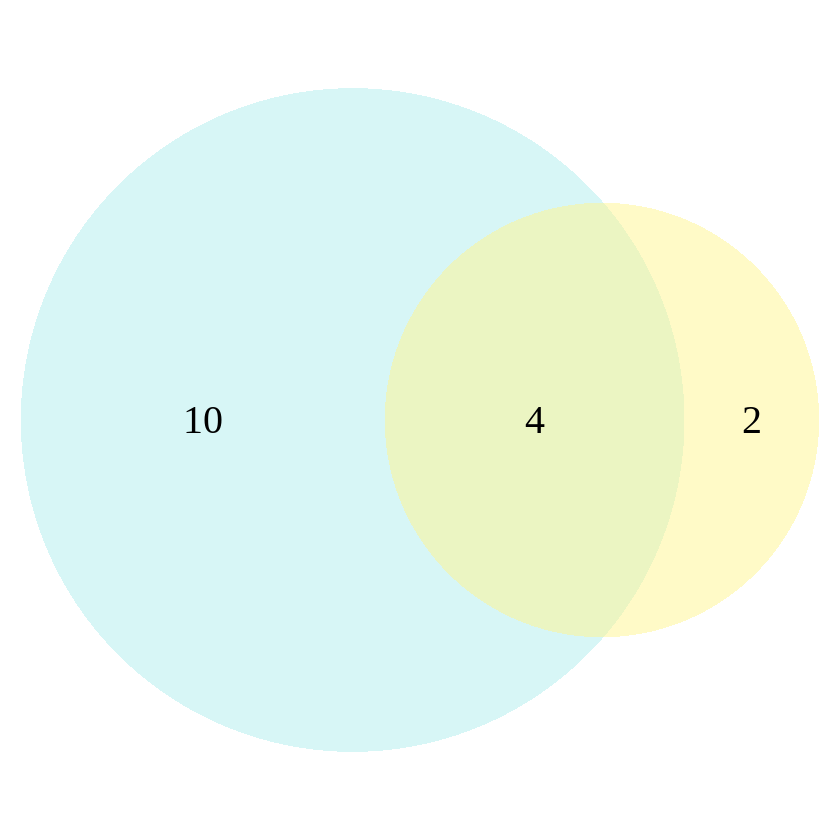

In [ ]:
draw.pairwise.venn(
  area1 = length(up_genes[['nfkb']]$name),
  area2 = length(rownames(up_rna_genes[['nfkb']])),
  cross.area = length(intersect(rownames(up_rna_genes[['nfkb']]), up_genes[['nfkb']]$name)), 
  lty = "blank", 
  fill = c( "khaki1","paleturquoise"),
  cex = 2,
  cat.cex = 1)

DOWN_NFkB

(polygon[GRID.polygon.3912], polygon[GRID.polygon.3913], polygon[GRID.polygon.3914], polygon[GRID.polygon.3915], text[GRID.text.3916], text[GRID.text.3917], text[GRID.text.3918], text[GRID.text.3919]) 

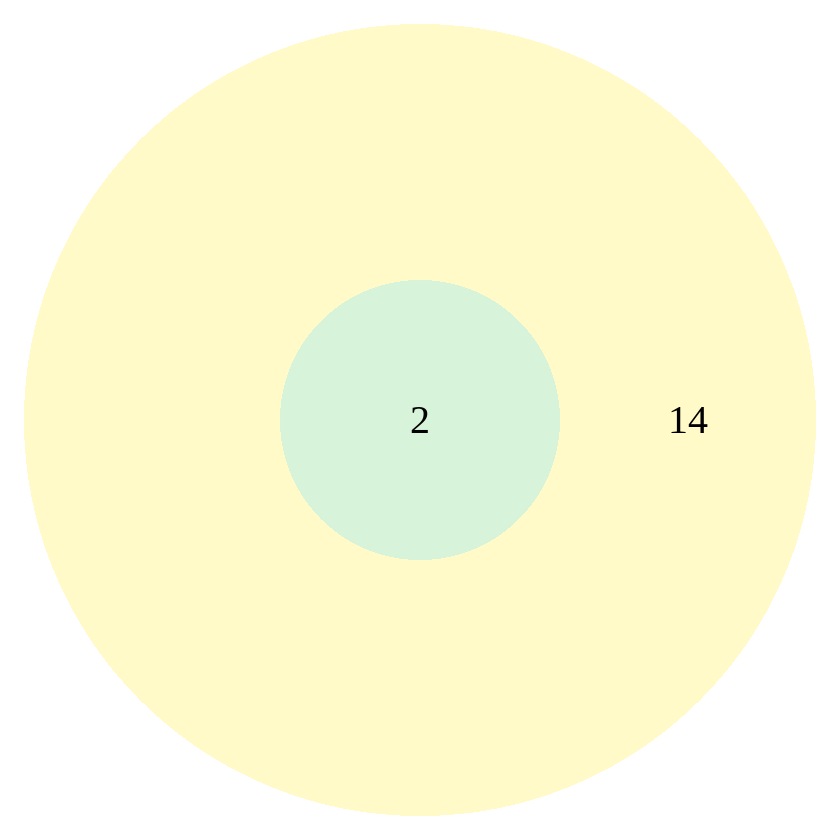

In [ ]:
draw.pairwise.venn(
  area1 = length(down_genes[['nfkb']]$name),
  area2 = length(rownames(down_rna_genes[['nfkb']])),
  cross.area = length(intersect(rownames(down_rna_genes[['nfkb']]), down_genes[['nfkb']]$name)), 
  lty = "blank", 
  fill =  c( "khaki1","paleturquoise"),
  cex = 2,
  cat.cex = 1)

# GSEA

# GSEA

## scRNA GSEA

In [ ]:
head(res_scrna)

,name,fc,pvalue,log2fc
,<chr>,<dbl>,<dbl>,<dbl>
1,Mrpl15,0.8561015,1.588210e-40,-0.224146290
2,Lypla1,0.9869158,1.476162e-09,-0.019001027
3,Gm37988,0.9997660,4.958114e-01,-0.000337565
4,Tcea1,0.8246107,3.610119e-43,-0.278214927
5,Rgs20,0.9858808,2.354869e-05,-0.020514837
6,Atp6v1h,1.1638874,4.307872e-07,0.218951431


In [ ]:
fc <- res_scrna$log2fc

In [ ]:
names(fc) <- res_scrna$name

In [ ]:
fc <- na.omit(fc)
fc <- sort(fc, decreasing = TRUE)

In [ ]:
gene_sets <- lapply(genes, function(x){x$SYMBOL})
names(gene_sets) <- names(genes)

In [ ]:
str(fc)

 Named num [1:17010] 1.8 1.5 1.34 1.32 1.2 ...
 - attr(*, "names")= chr [1:17010] "Ptn" "Col3a1" "Selenop" "Igfbp4" ...


In [ ]:
str(gene_sets)

List of 5
 $ nfkb        : chr [1:55] "Irak1" "Card10" "Chuk" "Dicer1" ...
 $ hdac        : chr [1:290] "Srcap" "Srcap" "Gm42715" "Morf4l1" ...
 $ hat         : chr [1:280] "Kat8" "Kat8" "Crebbp" "Crebbp" ...
 $ inflammatory: chr [1:1238] "Ms4a2" "Ptgs2" "Il17f" "Fn1" ...
 $ hdac_sub    : chr [1:126] "Hdac4" "Hdac9" "Hdac9" "Hdac9" ...


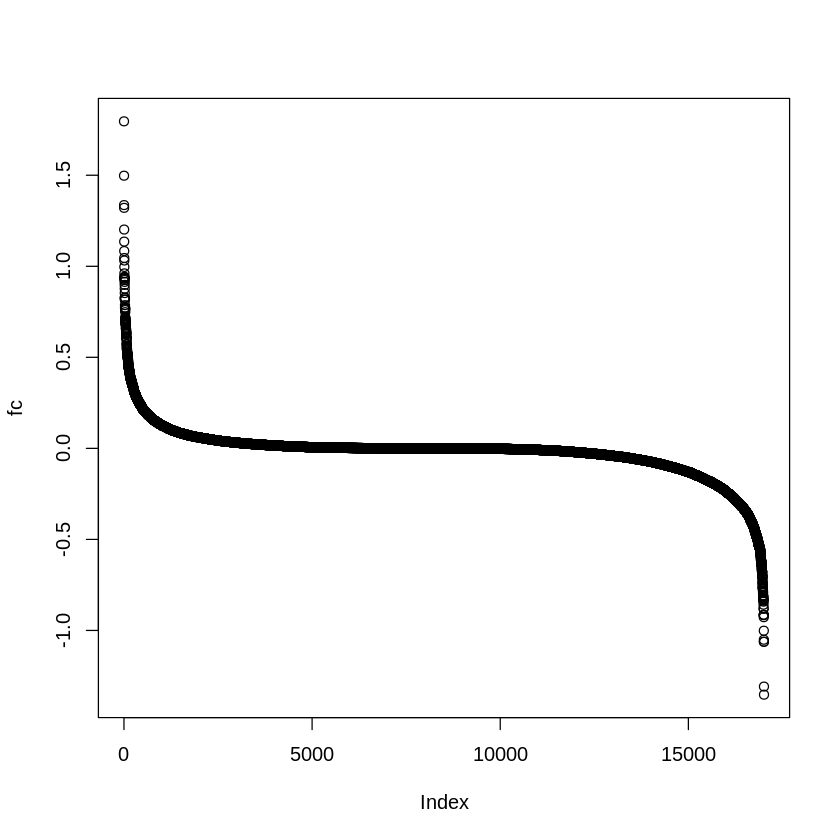

In [ ]:
plot(fc)

Using genes from each categories as a gene set 

In [ ]:
set.seed(1)
fgseaRes <-  fgseaMultilevel(pathways = gene_sets, 
                  stats    = fc,
                  minSize  = 15,
                  maxSize  = 2000,
                  nPermSimple = 5000)

In [ ]:
head(fgseaRes)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hat,0.9007491,0.9358431,0.01421361,-0.3385241,-0.7275960,39,"Naa50 , Hat1 , Msl3 , Brca2 , Kat2a , Tada2a, Taf10 , Phf14 , Med24 , Kat14 , Brpf1 , Taf1 , Kat7"
hdac,0.6032689,0.9358431,0.02093714,-0.3990011,-0.9334043,73,"Anp32e , Cbx5 , Sap18 , Hdac3 , Mbd3 , Tbl1x , Suds3 , Sap30 , Hint1 , Csnk2a1, Ruvbl1 , Ruvbl2 , Ing2 , Mbd2 , Gatad2a, Brd8 , Mta2 , Rbbp7 , Ncor1 , Chd3 , Brms1 , Hdac1 , Chd4"
hdac_sub,0.9358431,0.9358431,0.01317096,-0.3222040,-0.6966871,40,"Cbx5 , Sap18, Hdac3, Tbl1x, Sap30, Hint1"
inflammatory,0.2575107,0.6437768,0.18591379,0.3145639,1.0368256,318,"Ptn , Igfbp4 , Cd47 , F2r , Vcam1 , Hif1a , Gja1 , Il1r1 , Plscr1 , Nfe2l2 , Ly96 , Mecom , Anxa1 , Cebpb , Lyn , Camk1d , Ninj1 , Psen2 , Aim2 , Kdm6b , Casp6 , Serpinb1a, Itgav , Sgms1 , Stat3 , Cxcl1 , Nfkbiz , Ccl6 , Fn1 , Pld3 , Tgfb1 , Tnfrsf1a , Scyl1 , Ap3b1 , Chst2 , F8 , Tlr4 , Hdac5 , Pla2g7 , Snap23"
nfkb,0.1825149,0.6437768,0.05313428,-0.6090626,-1.2270663,26,"Traf4, Irak2, Cops8, Akt1 , Chuk , Zfp91, Irak1, Tirap"


In [ ]:
sprintf('%s:p-value %f',fgseaRes[grepl('hat', fgseaRes$pathway),]$pathway, fgseaRes$pval)

[1] "hat:p-value 0.900749" "hat:p-value 0.603269" "hat:p-value 0.935843"
[4] "hat:p-value 0.257511" "hat:p-value 0.182515"

In [ ]:
ep <- lapply(names(genes), function(x){plotEnrichment(gene_sets[[x]],
               fc) + labs(title=sprintf('%s: p-value %f',fgseaRes[grepl(x, fgseaRes$pathway),]$pathway, fgseaRes[grepl(x, fgseaRes$pathway),]$pval)) +geom_line(color = 'blue')
  })


In [ ]:
names(ep) <- names(genes)

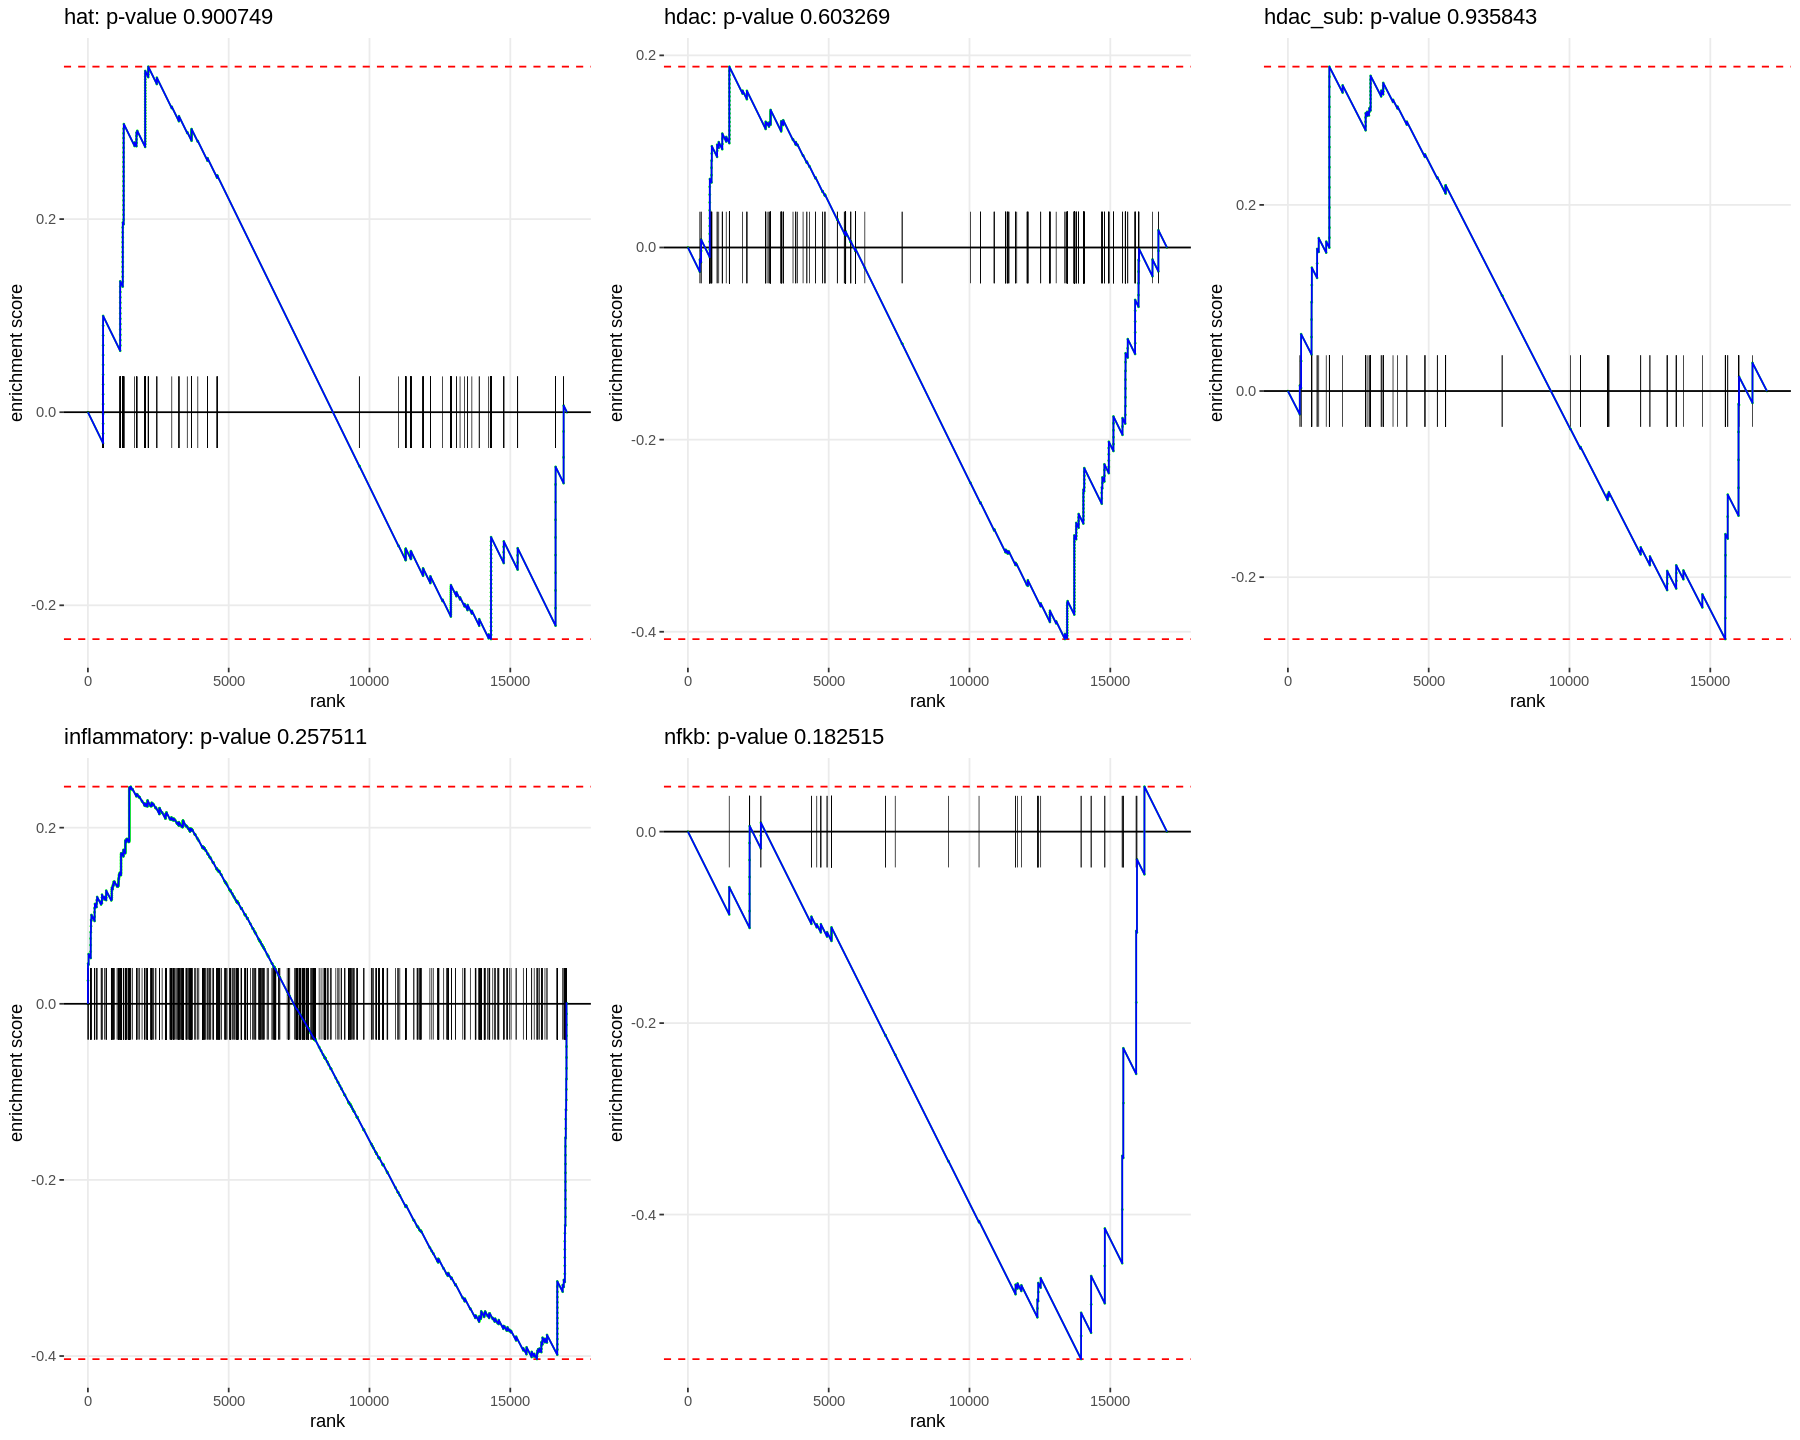

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
plot_grid(ep[['hat']], ep[['hdac']], ep[['hdac_sub']], ep[['inflammatory']], ep[['nfkb']])

## RNA GSEA

Using log2fc from deseq2 as the preranked list and each categories as a gene set 

In [ ]:
l2fc <- res$log2FoldChange

In [ ]:
names(l2fc) <- rownames(res)

In [ ]:
l2fc <- na.omit(l2fc)
l2fc <- sort(l2fc, decreasing = TRUE)

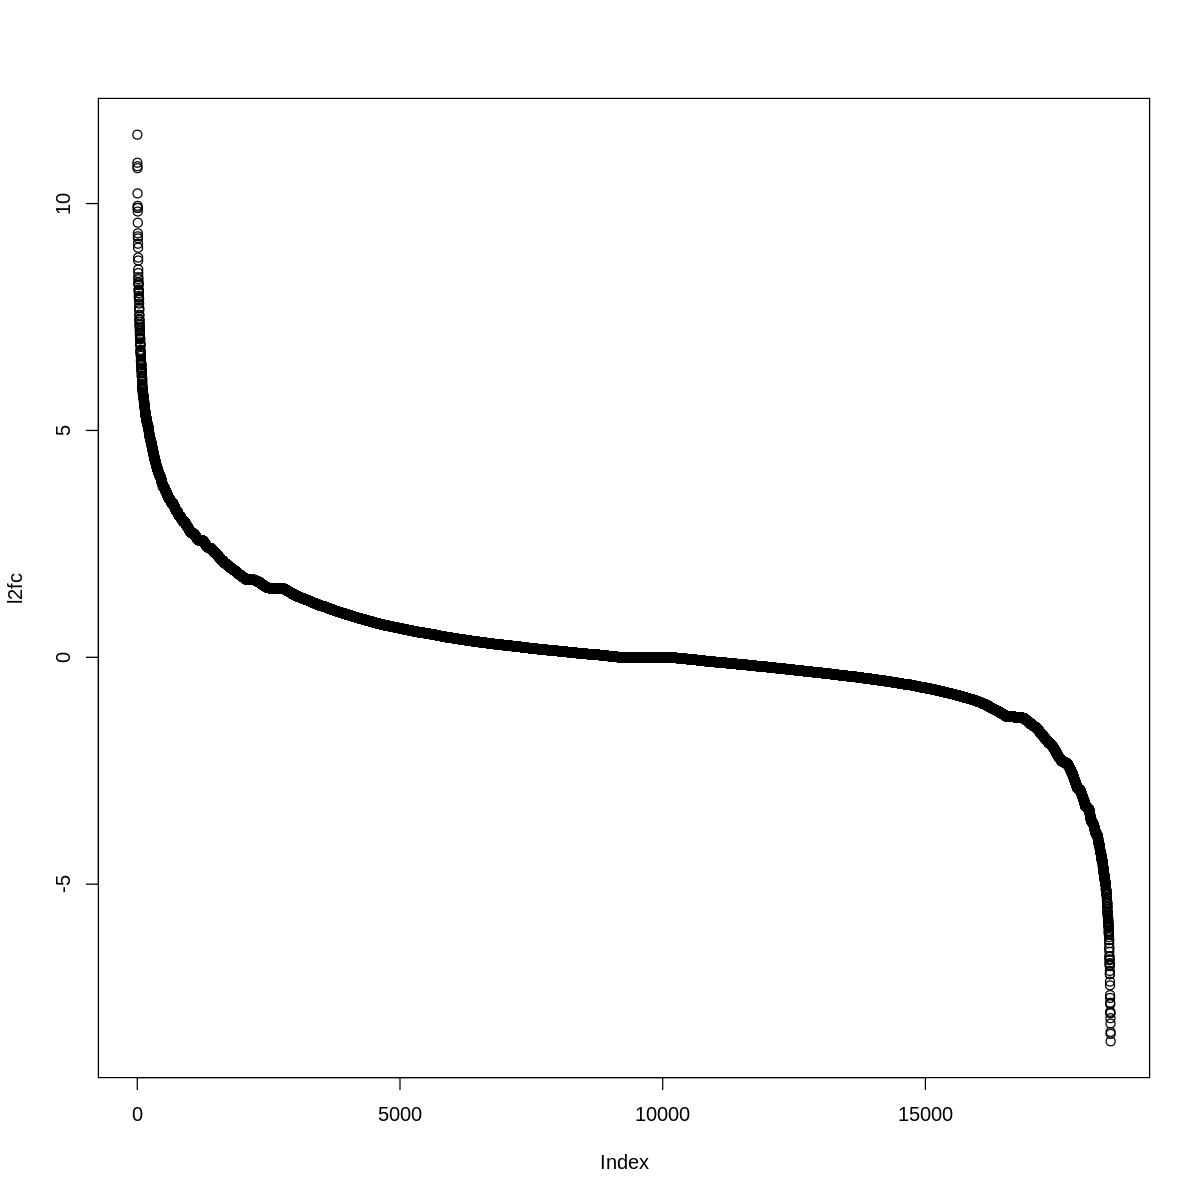

In [ ]:
plot(l2fc)

In [ ]:
set.seed(2)
fgseaRes <-  fgseaMultilevel(pathways = gene_sets, 
                  stats    = l2fc,
                  minSize  = 15,
                  maxSize  = 2000,
                  nPermSimple = 5000)

In [ ]:
head(fgseaRes)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hat,0.9859872611,0.9859872611,0.03047550,-0.2126697,-0.6324653,33,"Hat1 , Mettl8, Tada3 , Taf10 , Naa50 , Tada2a, Taf9 , Ep300 , Supt7l, Kat2a , Gtf3c4, Epc2 , Atf2"
hdac,0.6878306878,0.8597883598,0.01960735,0.2933102,0.8842303,73,"Tal1 , Hdac7, Mecom"
hdac_sub,0.2275882013,0.3793136688,0.04722432,0.4278237,1.1736620,41,"Tal1 , Hdac7, Mecom"
inflammatory,0.0000489639,0.0002448195,0.55733224,0.4263945,1.5032058,382,"Ccr7 , Cxcl5 , Clec7a , Hc , Stab1 , Il18rap , P2rx1 , Pik3cg , C3ar1 , Cnr2 , C2cd4a , Igfbp4 , Ccl6 , Bmp6 , Cxcl3 , Naip2 , Hdac7 , Cxcl2 , Il1a , Ffar3 , Pf4 , Lat , Tlr12 , Tlr4 , Npff , F2r , Cd40 , Mecom , Ccr6 , Ly86 , Tnfrsf4 , Pla2g3 , Tlr5 , Il5ra , Cd180 , Bmp2 , Pla2g2e , Tnf , Gbp5 , Tac1 , Ciita , Serpinf2, F2 , Nr1h4 , Fcgr1 , Naip7 , Tlr6 , Il4 , Il15 , Il17c , Il1rl2 , Ly96 , Il31ra , Casp4 , Aif1 , Cxcl1 , Orm2 , Cxcr2 , Pnma1 , Havcr2 , Itgb2l , Rarres2 , Chia , Pla2g2d , Lbp , Ptgfr , Notch1 , Hfe , Ager , Naip1 , C4a , Ecm1 , Aim2 , Tlr3 , Camk1d , Plp1 , Chst1 , Ak7 , Fut7 , Pik3cd , Naip5 , Tnfaip3 , Fn1 , AI182371, Stat5b , Pstpip1 , Ccl1 , Defb1 , Il6 , Ggt5 , Selp , Cd47 , Sigirr , Naip6 , Cd300a , Ptgs1 , Il17f , Ccl22 , Krt16 , Adora3 , Ccr1 , Cxcr3 , Il18r1 , Nlrp3 , Orm3 , S100a8 , Tlr9 , Ccl17 , Ffar2 , Ccr1l1 , Nfkbid , Tcirg1 , Syk , Ccr4"
nfkb,0.0411940299,0.1029850746,0.12132984,0.5724843,1.4564862,28,"Tnfsf15, Tlr4 , Ikbke , Mas1 , Ripk3 , Card10 , Akt1 , Traf2 , Relb , Traf6 , Irak1 , Map3k7 , Zfp91 , Ppp4c , Malt1 , Irak2 , Dicer1 , Chuk , Nfkb2"


In [ ]:
ep <- lapply(names(genes), function(x){plotEnrichment(gene_sets[[x]],
               l2fc) + labs(title=sprintf('%s: p-value %f',fgseaRes[grepl(x, fgseaRes$pathway),]$pathway, fgseaRes[grepl(x, fgseaRes$pathway),]$pval)) +geom_line(color = 'blue')
               })

In [ ]:
names(ep) <- names(genes)

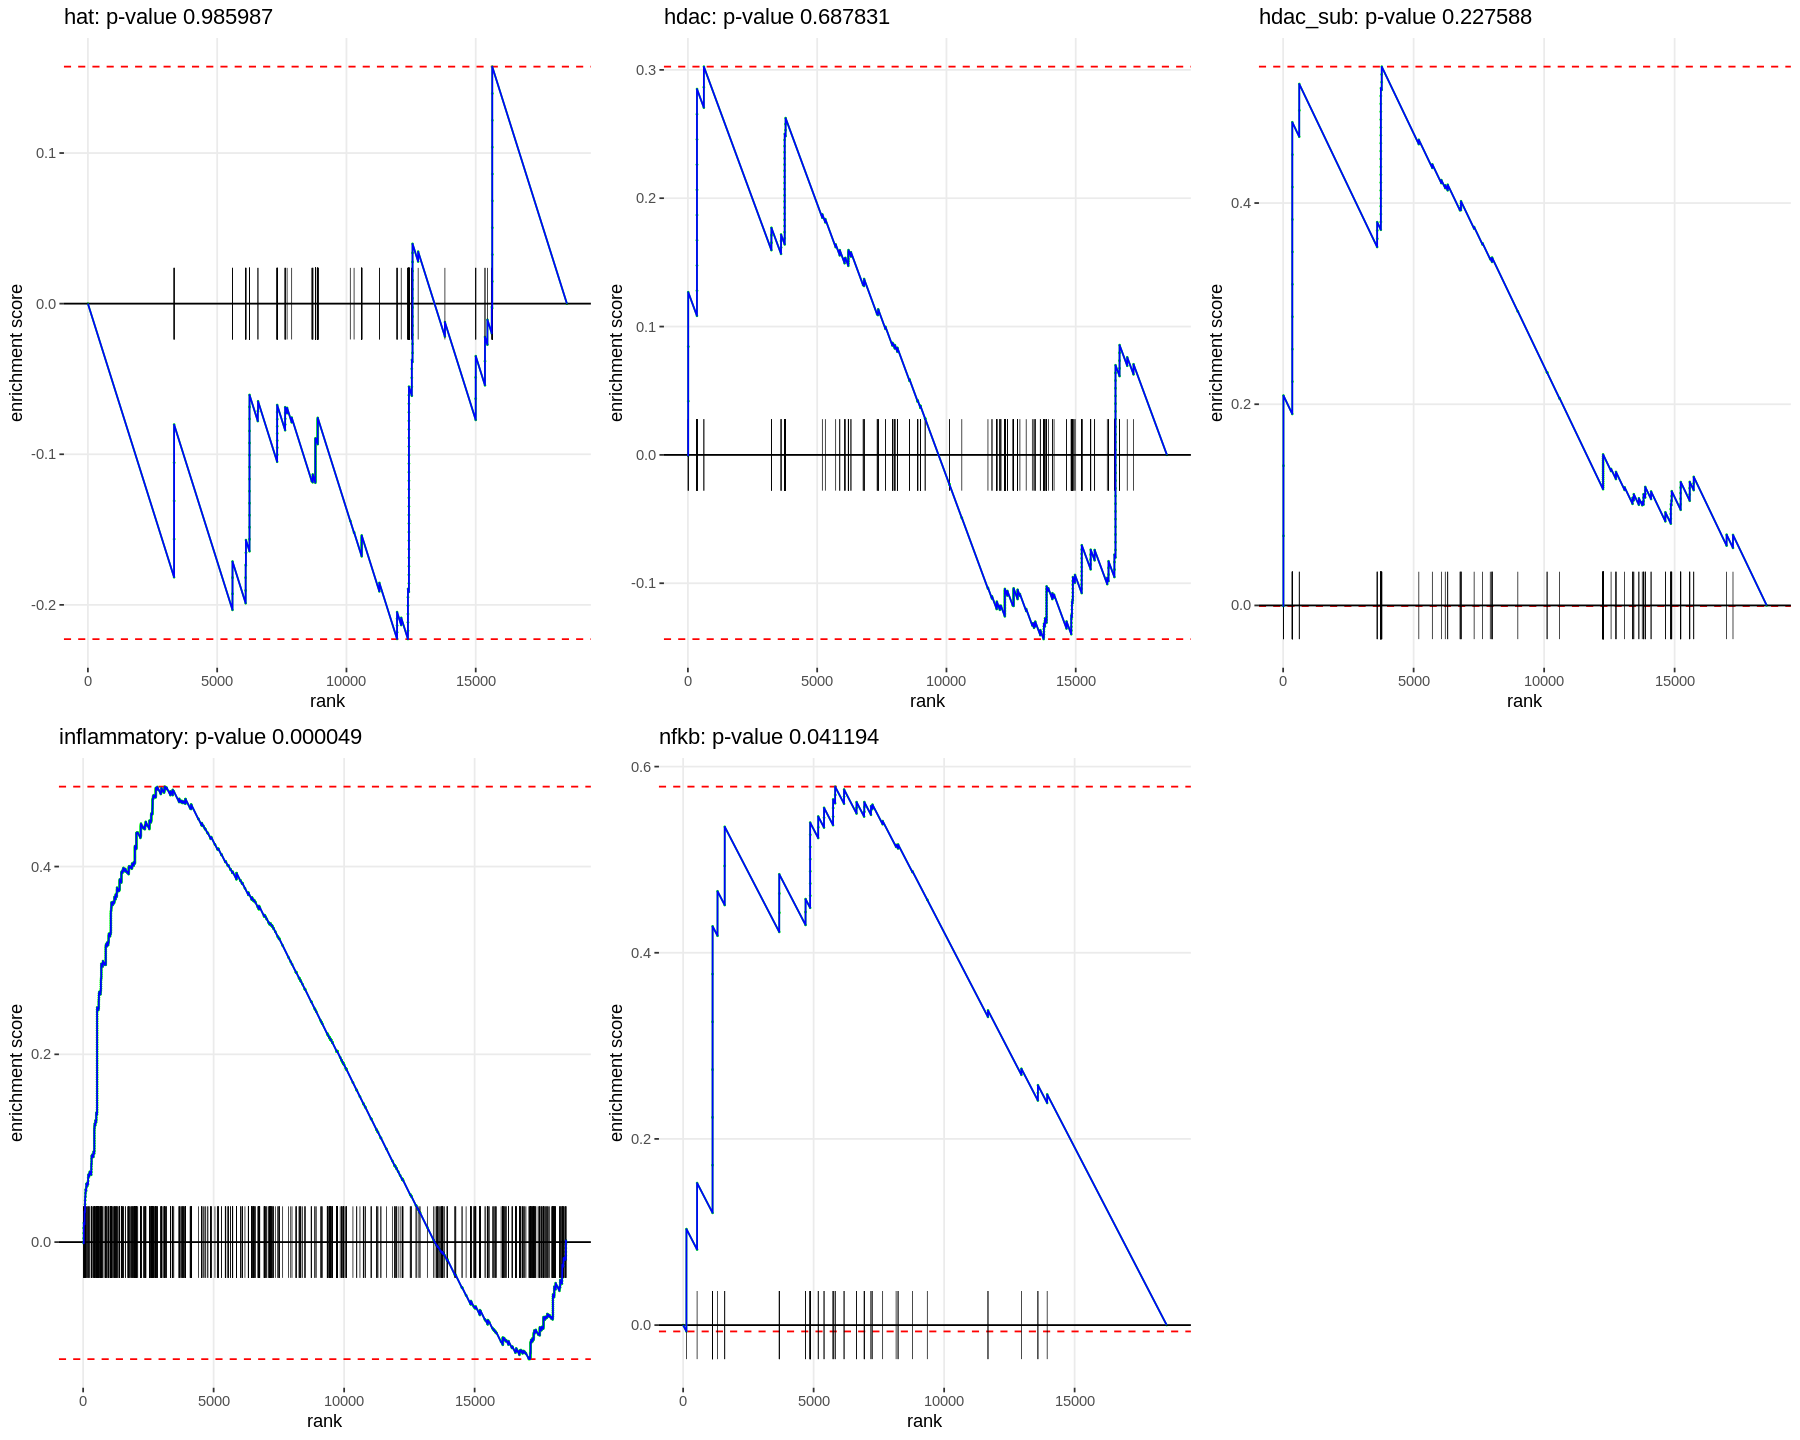

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
plot_grid(ep[['hat']], ep[['hdac']], ep[['hdac_sub']], ep[['inflammatory']], ep[['nfkb']])

In [ ]:
Sys.time() - start_time0

In [ ]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1                            
 [2] fgsea_1.16.0                             
 [3] clusterProfiler_3.18.1                   
 [4] phenoTest_1.38.0                         
 [5] Hmisc_4.5-0                              